# Improving a Neural Network based universal approximator with Fourier series  

Neural Networks, provided that they are given the "right" activation function (see below about activation function) are known to be "universal approximators". 
This is formally experessed by the Universal Approximation Theorem defined by Hornik and al in 1991:  





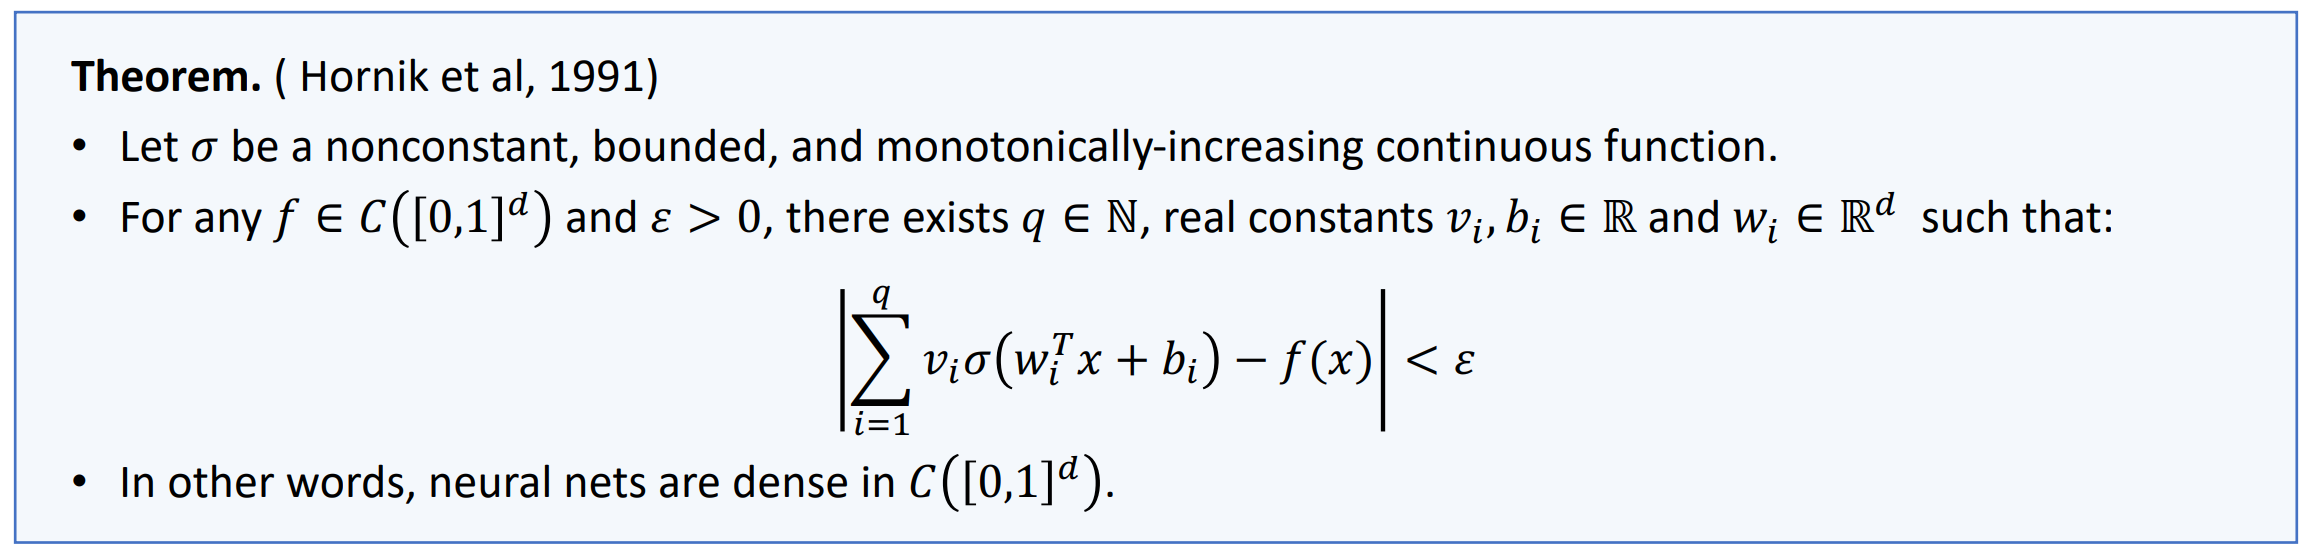

As you would have remarked the "right" activation function here refers to one that is non constant, monotically increasing continuous and bounded within a function definition space. With this definition Relu would be the first one can think about (even if there is one discontinuity in zero for ReLU it is continuous at almost all points), but you can also have, in theory, an approximator with the sigmoid, with tanh or even with the linear function. 


**It means that you can approximative any continuous function within a specific range with even a single hidden layer neural net provided you add enough neurons.**



This behavior of neural network is not surprising given their main goal: linking data inputs to outputs with the highest precision possible while avoiding overfitting. They were meant, using the data sample that we give them, to approximate the unknown relationship that is linking data input to the output data (or even to unobserved output in unsupervised methods) in a generalized functional form being composed of a series of linear combinations and activation functions.  

However, a very complex function might not be so easy to approximate with a shallow neural network, especially with a reasonable number of epoch (iteration over the whole sample) or reasonable number of neurons. 

One idea that is worth exploring is how one could use one other famous function approximation method that has been aroun for centuries: the Fourier series principle. Fourier series rationale, again, is very strong mathematically but analytical solutions can be hard to find: for 2 reasons: the necessity to integrate over functional spaces that may be complex and the fact that a Fourier series has an infinite number of terms and the implementation of a good approximation without having too high a number of terms can be difficult.   

In addition, the calculation power of neural net tools, if we have a converging net, will be very helpful with the approximation. 



# Let's confront this tool / method given by neural network to another very well know function approximation technique: Fourier series 


*Important Remark: We are not trying here to use Neural Net in the way they are usually used for, ie, forecasting. We simply use and explore what we can do around their approximation functionality but the datasets we are going to use are theoretical, or random, and there is nothing to predict from it*

First, we can look at an approximation with a classical neural net and then, we'll look at introducing some Fourier principle in there. 

Procedure: 

1.   Define a random target functions to approximate and a bounded definition space S (we will work in dimension 2 here, for easier readability, so S is a segment).
2.   Define a data tensor (vector here) : x and a target variable tensor y that will translate the target functions into a discretized series of points over the definition space S. We will try 2 x tensors : a linespace (discretized values over S representing the abscisse line) and an x tensor made of random points between 0 and 1
3.  Define a simple Neural Net with ReLU with one hidden layer using the Sequential module from Pytorch
4. Run the neural network over the different target functions and record the error score (Mean Square Error loss), the number of epoch necessary for a given score and the error evolution.
5. Make the same test but replacing the x tensor by columns of sin and cosine function with a regular period : sin(nt) and cos(nt) with n a regular number. As such the network will replicate a Fourier series with a degree that we can fnetune according to how many columns we put in the x tensors and we can check if we obtain faster convergence. First we can try with a linear activation function (to really stick to the Fourier definition) and then even with a ReLU activation function. 
6. We will check what are the coefficients that are given by the neural network and if they correspond to the Fourier theorical defitition of the series coefficients.
6. Once we have establish what the best method is, we can use it to approximate other random functions, like, for example, financial timeseries.  



*Remark: The choice of the optimizer here is not a matter of interest : we will use a classical Stochasti Gradient Descent Optimizer.A more sophisticated optimizer could yield faster result but this is not what we are testing here but how to improve the neural net approximation behavior using Fourier series*

**1 ) Let's proceed to the implementation of a simple single layer neural net and test this approximator.**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import torch.optim as optim

Let's define a polynomial function that will be the ones to approximate:
$$
f(t)=at^{4}+bt^{3}+ct^{2}+dt+e,
$$

In order to add more randomness to this polynomial function, we can add some flat parts

In [98]:
# we will have to define both a data tensor x, and a target variable tensor 
x= torch.arange(-10,4,0.1).view(-1, 1)
y = x**4 + 2*x**3 - 12*x**2 -2*x + 6
y = torch.where(x < -5, torch.zeros_like(x), y)

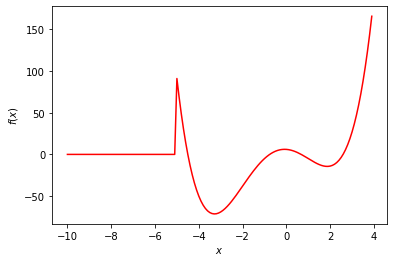

In [94]:
# Display our target function

def display_y(x, y):
  fig, ax = plt.subplots()
  plt.plot(x.numpy(), y.numpy(),'r-',label='Target function to approximate')
  plt.xlabel('$x$')
  plt.ylabel('$f(x)$')
  plt.show()
  ax.legend()
  plt.show()

display_y(x, y)

In [10]:
# We define two helper functions to plot the approximation against the target function and to plot the evolution of the loss value along the different epochs. 

def plotApproximation(y,y_pred):
  plt.figure(figsize=(6, 4))
  plt.plot(y.detach().numpy(),'b-')
  plt.plot(y_pred.detach().numpy(),'r-*')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title('Approximation with the neural network')
  plt.show()



In [11]:
def plotLoss(Niter, save_loss_series):
  fig, ax = plt.subplots()
  plt.plot(range(Niter), save_loss_series, 'b-',label='Training error')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  ax.legend()
  plt.show()

In [99]:
class SimpleNet_Training:
  def __init__(self, target_output, input_dt, q1=5, Niter = 100):
    self.target_output = target_output
    self.input_dt = input_dt
    self.Niter = Niter
    self.D_in = self.input_dt.size()[1]
    self.D_out = self.target_output.size()[1]
    self.q1 = q1
    self.mynet = self.mynet()
    self.loss = nn.MSELoss()
    self.optimizer = optim.SGD(self.mynet.parameters(), lr=0.001, momentum=0.9)
    self.y_pred , self.loss_series = self.train_net()
    
  def mynet(self):
    return nn.Sequential(OrderedDict([('linear1', nn.Linear(self.D_in, self.q1)),
                                    ('relu1', nn.ReLU()),
                                     ('linear2', nn.Linear(self.q1, self.D_out)) 
                                  ]))
  
  def train_net(self):
    loss_series = []
    for epoch in range(0, self.Niter):
      output  = self.mynet(self.input_dt)
      l = self.loss(output, self.target_output)
      # print statistics
      savedLoss = 0.0
      savedLoss += l.item()
      loss_series.append(savedLoss)
      if epoch % 10 == 9:    
        print('[%d, %2d] loss: %.3f' % (epoch-9, epoch + 1, savedLoss))
      self.optimizer.zero_grad()
      l.backward()
      self.optimizer.step()
    return output, loss_series

     
# we define the loss as the MSE loss and optimizer as the classical Stochastic Gradient with momentum (both harcoded) 
# but here we look at the net architecture and can let the rest : loss or optimizer unchanged.

[0, 10] loss: 1355.377
[10, 20] loss: 1068.072
[20, 30] loss: 939.144
[30, 40] loss: 846.140
[40, 50] loss: 836.009
[50, 60] loss: 807.693
[60, 70] loss: 795.309
[70, 80] loss: 774.757
[80, 90] loss: 748.194
[90, 100] loss: 712.532
[100, 110] loss: 672.313
[110, 120] loss: 631.596
[120, 130] loss: 569.471
[130, 140] loss: 514.503
[140, 150] loss: 466.476
[150, 160] loss: 426.629
[160, 170] loss: 394.855
[170, 180] loss: 367.296
[180, 190] loss: 344.886
[190, 200] loss: 327.582
[200, 210] loss: 333.391
[210, 220] loss: 303.420
[220, 230] loss: 310.176
[230, 240] loss: 285.563
[240, 250] loss: 325.778
[250, 260] loss: 326.627
[260, 270] loss: 275.793
[270, 280] loss: 358.046
[280, 290] loss: 334.497
[290, 300] loss: 272.068
[300, 310] loss: 343.016
[310, 320] loss: 337.754
[320, 330] loss: 275.649
[330, 340] loss: 346.800
[340, 350] loss: 310.094
[350, 360] loss: 270.415
[360, 370] loss: 292.132
[370, 380] loss: 258.670
[380, 390] loss: 257.447
[390, 400] loss: 255.621
[400, 410] loss: 2

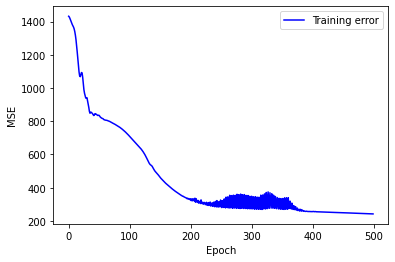

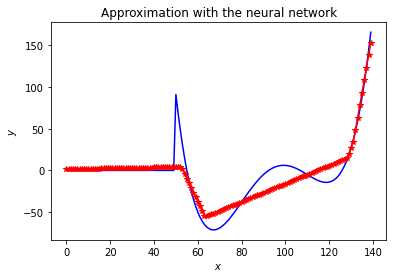

In [100]:
mynet = SimpleNet_Training(target_output = y, input_dt = x, Niter=500)
y_pred , savedLoss = mynet.y_pred, mynet.loss_series
Niter = mynet.Niter
plotLoss(Niter=Niter, save_loss_series=savedLoss)
plotApproximation(y = y, y_pred = y_pred)

Results are pretty poor with a classic shallow network and the algorithm gets stuck after a about 100 iterations.
Of course, as you can see below, a deeper network, with more hidden layers, more complex architecture, and more neurons can do much better but this does not bring a lot with regards to the universal approximation theorem which states even one layer is enough. 

[0, 10] loss: 1402.771
[10, 20] loss: 1323.851
[20, 30] loss: 1252.839
[30, 40] loss: 1206.688
[40, 50] loss: 1163.282
[50, 60] loss: 1116.360
[60, 70] loss: 1049.667
[70, 80] loss: 949.119
[80, 90] loss: 826.728
[90, 100] loss: 704.112
[100, 110] loss: 601.034
[110, 120] loss: 594.142
[120, 130] loss: 541.875
[130, 140] loss: 449.585
[140, 150] loss: 358.491
[150, 160] loss: 322.221
[160, 170] loss: 290.596
[170, 180] loss: 266.279
[180, 190] loss: 247.663
[190, 200] loss: 232.726
[200, 210] loss: 220.257
[210, 220] loss: 209.716
[220, 230] loss: 200.720
[230, 240] loss: 192.960
[240, 250] loss: 186.230
[250, 260] loss: 180.412
[260, 270] loss: 175.333
[270, 280] loss: 170.844
[280, 290] loss: 166.854
[290, 300] loss: 163.282
[300, 310] loss: 160.069
[310, 320] loss: 157.170
[320, 330] loss: 154.544
[330, 340] loss: 152.156
[340, 350] loss: 149.972
[350, 360] loss: 147.965
[360, 370] loss: 146.111
[370, 380] loss: 144.399
[380, 390] loss: 142.816
[390, 400] loss: 141.343
[400, 410] lo

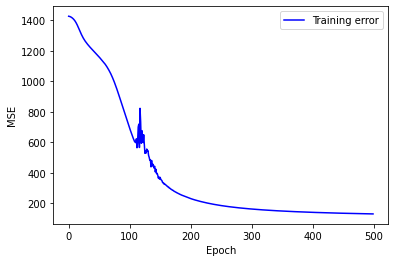

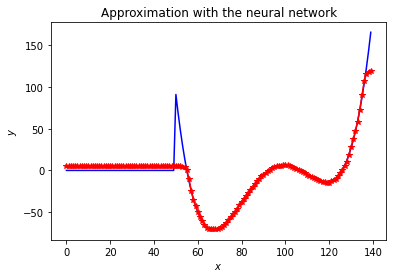

In [40]:
# We can work with a deeper net to have better results but we dont want this: 

Niter = 500
D_in = x.size()[1]
D_out = y.size()[1]


q1 = 20
q2 = 20
q3 = 20

mynet2 = nn.Sequential(OrderedDict([('linear1', nn.Linear(D_in, q1)),
                                    ('relu1', nn.ReLU()),
                                     ('linear2', nn.Linear(q1, q2)), 
                                    ('sigmoid1', nn.Sigmoid()),
                                  ('linear2', nn.Linear(q2, q3)), 
                                  ('relu2', nn.ReLU()),
                                    ('linear3', nn.Linear(q3, D_out))
                                  ]))

loss = nn.MSELoss()
optimizer = optim.SGD(mynet2.parameters(), lr=0.001, momentum=0.9)



# Model 2: is linear and one relu: to try on the x and the x fourier

save_loss_series = []
for epoch in range(0, Niter):
  output  = mynet2(x)
  l = loss(output, y)
  # print statistics
  savedLoss = 0.0
  savedLoss += l.item()
  save_loss_series.append(savedLoss)
  if epoch % 10 == 9:    
    print('[%d, %2d] loss: %.3f' %
          (epoch-9, epoch + 1, savedLoss))
  
  optimizer.zero_grad()

  l.backward()

  optimizer.step()

plotLoss(Niter=Niter, save_loss_series=save_loss_series)
plotApproximation(y = y, y_pred = output)

*Remark: one may note that our neural net being a stochastic process, it is normal to have different results at each run. The loss to take into account should then be an average of the loss over several runs, provided convergence is ensured.*

# Reminder on how a Fourier series work

A fourier series is basically a way of approximating or representing a periodic function by a series of simple harmonic(sine and cosine) functions.



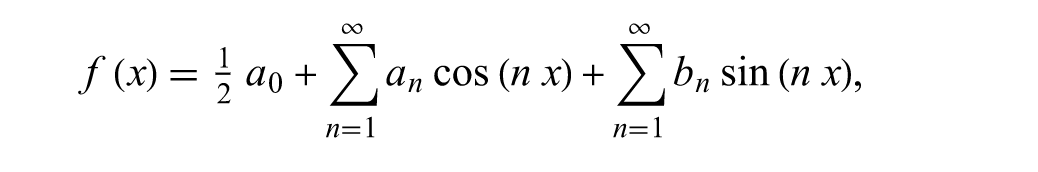

*Remark : For non periodic function: it is better then to talk about the decomposition not of the function itself into a Fourier series but of its extension-by-periodicity aka their Fourier transform.  The right terminology would be to talk about Fourier series only for periodic function and thus to add the periodicity in the formula above but for simplicity, we will not take it into account here.
We aim at approximating both periodic and non periodic functions*

The way we are going to "introduce" a Fourier series behavior or force our network to use Fourier series is simply by modifying the initial dataset it is going to use from the real line to several columns containing the sin and cosine function at a different period (a different n). 
We can then assess how many terms we need our series to have to ba able to make good approximations (basically varying the value of n)

As a Neural Network job is to make linear combinations of data followed by activation function, using an activation function in our "Fourier" Net would not be strictly speeking composing a Fourier series because you would add some discontinuity to it (which is precisely the goal of neural net activation functions: add some discontinuity to approximate a complex function's disparities better).
We can then check what performs better: with or without activation function 

One last interesting point would be to look at the weight that are calculated by the network, as Pytorch enables us to get them at the end of the traning, and compare their value to the theoretical Fourier coefficients 

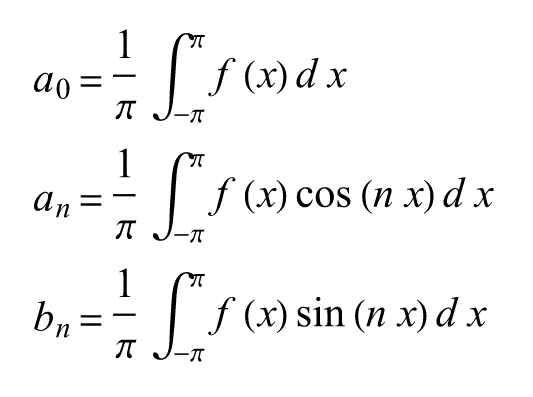

In [41]:
# We create the x dataset that will be made of sin and cosin columns fourier plus a constant: then the sumation will be done by the network

x0 = x*(1/np.pi) # we choose 2 as value for the initial constant
x1 = np.sin(1*x)
x2 = np.cos(1*x)
x3 = np.sin(2*x)
x4 = np.cos(2*x)


x_fourier = torch.cat((x0, x1, x2, x3, x4), -1)


[0, 10] loss: 1410.667
[10, 20] loss: 1344.396
[20, 30] loss: 1148.715
[30, 40] loss: 672.683
[40, 50] loss: 409.445
[50, 60] loss: 235.339
[60, 70] loss: 181.252
[70, 80] loss: 148.606
[80, 90] loss: 137.228
[90, 100] loss: 130.783
[100, 110] loss: 125.915
[110, 120] loss: 122.545
[120, 130] loss: 119.923
[130, 140] loss: 118.022
[140, 150] loss: 116.665
[150, 160] loss: 115.746
[160, 170] loss: 115.092
[170, 180] loss: 114.574
[180, 190] loss: 114.185
[190, 200] loss: 113.858
[200, 210] loss: 113.567
[210, 220] loss: 113.294
[220, 230] loss: 113.066
[230, 240] loss: 112.881
[240, 250] loss: 112.724
[250, 260] loss: 112.578
[260, 270] loss: 112.447
[270, 280] loss: 112.334
[280, 290] loss: 112.235
[290, 300] loss: 112.149
[300, 310] loss: 112.072
[310, 320] loss: 112.003
[320, 330] loss: 111.941
[330, 340] loss: 111.886
[340, 350] loss: 111.834
[350, 360] loss: 111.784
[360, 370] loss: 111.737
[370, 380] loss: 111.694
[380, 390] loss: 111.654
[390, 400] loss: 111.617
[400, 410] loss: 

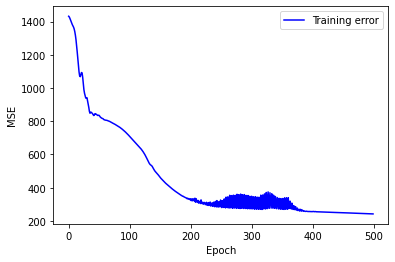

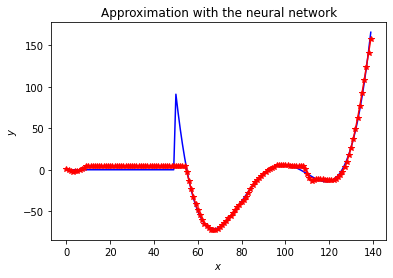

In [103]:
# We can reuse our first simple net with the new input

my_fnet = SimpleNet_Training(target_output = y, input_dt = x_fourier, Niter=500)
y_pred , savedLoss = my_fnet.y_pred, mynet.loss_series
Niter = my_fnet.Niter
plotLoss(Niter=Niter, save_loss_series=savedLoss)
plotApproximation(y = y, y_pred = y_pred)

**Findings : We can see directly that with our Simple Net : we can reproduce results as good as with a deeper net just by adding a dataset corresponding to a fourier series of second order (n =2 "only"). 
What we can also see is that the descent is much faster even than our deeper net, meaning this very simple change of providing the net with sines and cosines series makes the optimization much easier and faster.**

One may say that because of the ReLU step, this is not exactly a Fourier series as it adds some discontinuity, we can try without this ReLU step

[0, 10] loss: 1386.322
[10, 20] loss: 1316.410
[20, 30] loss: 1266.235
[30, 40] loss: 1267.927
[40, 50] loss: 1262.129
[50, 60] loss: 1262.314
[60, 70] loss: 1261.605
[70, 80] loss: 1261.657
[80, 90] loss: 1261.583
[90, 100] loss: 1261.591
[100, 110] loss: 1261.582
[110, 120] loss: 1261.583
[120, 130] loss: 1261.581
[130, 140] loss: 1261.582
[140, 150] loss: 1261.581
[150, 160] loss: 1261.581
[160, 170] loss: 1261.581
[170, 180] loss: 1261.581
[180, 190] loss: 1261.581
[190, 200] loss: 1261.581
[200, 210] loss: 1261.581
[210, 220] loss: 1261.581
[220, 230] loss: 1261.581
[230, 240] loss: 1261.581
[240, 250] loss: 1261.581
[250, 260] loss: 1261.581
[260, 270] loss: 1261.581
[270, 280] loss: 1261.581
[280, 290] loss: 1261.581
[290, 300] loss: 1261.581
[300, 310] loss: 1261.581
[310, 320] loss: 1261.581
[320, 330] loss: 1261.581
[330, 340] loss: 1261.581
[340, 350] loss: 1261.581
[350, 360] loss: 1261.581
[360, 370] loss: 1261.581
[370, 380] loss: 1261.581
[380, 390] loss: 1261.581
[390, 

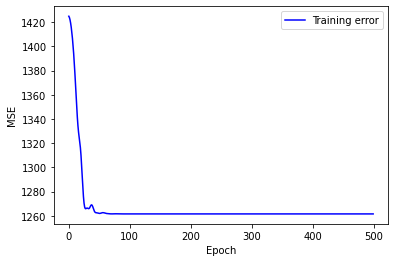

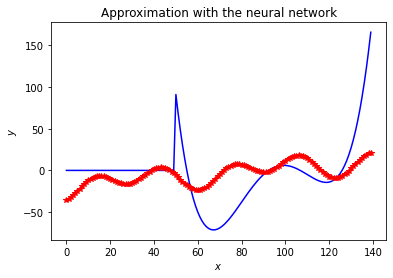

In [45]:
mynet_ = nn.Sequential(OrderedDict([('linear1', nn.Linear(x_fourier.size()[1], q1)),
                                    ('linear2', nn.Linear(q3, y.size()[1]))
                                  ]))

loss = nn.MSELoss()
optimizer = optim.SGD(mynet_.parameters(), lr=0.001, momentum=0.9)
save_loss_series = []
for epoch in range(0, 500):
  output  = mynet_(x_fourier)
  l = loss(output, y)
  # print statistics
  savedLoss = 0.0
  savedLoss += l.item()
  save_loss_series.append(savedLoss)
  if epoch % 10 == 9:    
    print('[%d, %2d] loss: %.3f' %
          (epoch-9, epoch + 1, savedLoss))
  
  optimizer.zero_grad()

  l.backward()

  optimizer.step()

plotLoss(Niter=500, save_loss_series=save_loss_series)
plotApproximation(y = y, y_pred = output)

It seems that with only a series of order 2, the algorithm gets stuck and that the use of ReLU enables a better and faster convergence. 

# One may now try a series of a superior order : we can try n = 8 to see how the net improves

In [104]:
# using a dataset corresponding to a longer series of sines and cosines
x5 = np.sin(3*x)
x6 =  np.cos(3*x)
x7 = np.sin(4*x)
x8 =  np.cos(4*x)

x9 = np.sin(5*x)
x10 =  np.cos(5*x)
x11 = np.sin(6*x)
x12 =  np.cos(6*x)

x13 = np.sin(7*x)
x14 =  np.cos(7*x)
x15 = np.sin(8*x)
x16 =  np.cos(8*x)

x_fourier2 = torch.cat((x_fourier, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16 ), -1)
 

[0, 10] loss: 1423.177
[10, 20] loss: 1384.041
[20, 30] loss: 1261.101
[30, 40] loss: 974.112
[40, 50] loss: 585.607
[50, 60] loss: 291.725
[60, 70] loss: 140.836
[70, 80] loss: 106.433
[80, 90] loss: 83.129
[90, 100] loss: 55.744
[100, 110] loss: 35.510
[110, 120] loss: 27.778
[120, 130] loss: 24.626
[130, 140] loss: 23.003
[140, 150] loss: 21.731
[150, 160] loss: 20.442
[160, 170] loss: 19.720
[170, 180] loss: 19.200
[180, 190] loss: 18.854
[190, 200] loss: 18.568
[200, 210] loss: 18.267
[210, 220] loss: 18.019
[220, 230] loss: 17.468
[230, 240] loss: 16.824
[240, 250] loss: 16.346
[250, 260] loss: 15.943
[260, 270] loss: 15.605
[270, 280] loss: 15.305
[280, 290] loss: 15.050
[290, 300] loss: 14.818
[300, 310] loss: 14.599
[310, 320] loss: 14.330
[320, 330] loss: 14.064
[330, 340] loss: 13.850
[340, 350] loss: 13.612
[350, 360] loss: 13.378
[360, 370] loss: 13.158
[370, 380] loss: 12.967
[380, 390] loss: 12.801
[390, 400] loss: 12.640
[400, 410] loss: 12.486
[410, 420] loss: 12.340
[

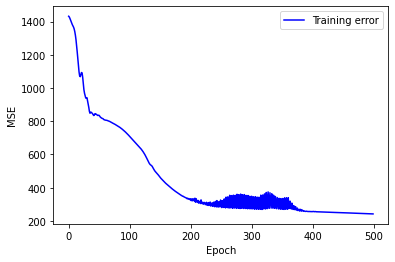

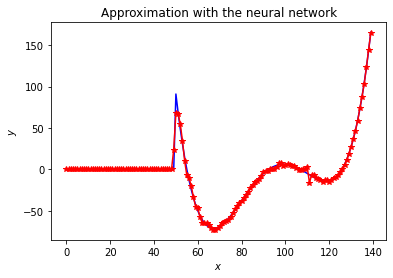

In [105]:
my_fnet = SimpleNet_Training(target_output = y, input_dt = x_fourier2, Niter=500)
y_pred , savedLoss = my_fnet.y_pred, mynet.loss_series
Niter = my_fnet.Niter
plotLoss(Niter=Niter, save_loss_series=savedLoss)
plotApproximation(y = y, y_pred = y_pred)

Results are better, not significantly better than with a shorter Fourier series, probably because we are reachning a very low loss level. We can try our net on other random functions, such as financial timeseries.

To do this, we may use the yahoo finance api to load these timeseries. 

In [54]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 15.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [55]:
!pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 4.5 MB/s 
     |████████████████████████████████| 83 kB 1.8 MB/s 
     |████████████████████████████████| 139 kB 39.3 MB/s 
     |████████████████████████████████| 112 kB 39.1 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=1e76bbac97663b4be413a72104763f2743d15f7ceb75f1066c52e041d89afcfd
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=41e34f4aa3995e60bd40ebb813fcb029a41123edf4fdca5c48a352c21d2cd2e5
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=8c993ace4b013f4a7568e102f3962a0b189075e55820c0a51cbbb

# Let's try this improved approximator on other function : for example financial stock series

In [56]:
# Let's try on other timeseries: 

import yfinance as yf
from yahoo_fin.stock_info import get_data

In [106]:
ticker_list = ["amzn", "msft", "ba"]
historical_datas = {}
for ticker in ticker_list:
    historical_datas[ticker] = get_data(ticker, start_date="01/01/2020")["close"]

In [107]:
# we convert to torch tensor and reshape so that it corresponds to the size of our x dataset
ba = torch.tensor(historical_datas["ba"].values, dtype=torch.float32)[:140].view(-1, 1)
amzn = torch.tensor(historical_datas["amzn"].values, dtype = torch.float32)[:140].view(-1, 1)
msft  = torch.tensor(historical_datas["msft"].values, dtype = torch.float32)[:140].view(-1, 1)

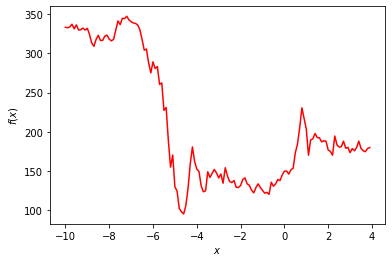

In [112]:

# Display obtained target function
display_y(x, ba)


[0, 10] loss: 20636.322
[10, 20] loss: 10044.377
[20, 30] loss: 3659.631
[30, 40] loss: 1108.341
[40, 50] loss: 499.203
[50, 60] loss: 187.514
[60, 70] loss: 103.647
[70, 80] loss: 70.024
[80, 90] loss: 58.893
[90, 100] loss: 53.455
[100, 110] loss: 50.735
[110, 120] loss: 49.210
[120, 130] loss: 48.048
[130, 140] loss: 47.189
[140, 150] loss: 45.968
[150, 160] loss: 44.544
[160, 170] loss: 43.470
[170, 180] loss: 42.681
[180, 190] loss: 41.615
[190, 200] loss: 40.627
[200, 210] loss: 40.127
[210, 220] loss: 39.880
[220, 230] loss: 39.660
[230, 240] loss: 39.466
[240, 250] loss: 39.300
[250, 260] loss: 39.142
[260, 270] loss: 38.995
[270, 280] loss: 38.857
[280, 290] loss: 38.735
[290, 300] loss: 38.617
[300, 310] loss: 38.510
[310, 320] loss: 38.409
[320, 330] loss: 38.314
[330, 340] loss: 38.226
[340, 350] loss: 38.074
[350, 360] loss: 37.922
[360, 370] loss: 37.794
[370, 380] loss: 37.686
[380, 390] loss: 37.588
[390, 400] loss: 37.498
[400, 410] loss: 37.417
[410, 420] loss: 37.341

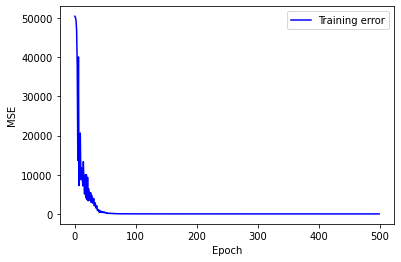

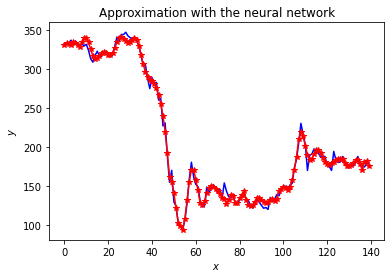

In [114]:
mynet = SimpleNet_Training(target_output = ba, input_dt = x_fourier2, Niter=500)
y_pred , savedLoss = mynet.y_pred, mynet.loss_series
Niter = mynet.Niter
plotLoss(Niter=Niter, save_loss_series=savedLoss)
plotApproximation(y = ba, y_pred = y_pred)